In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

In [2]:
# Load your cleaned dataset (or train.csv directly)
df = pd.read_csv("../datasets/clean_walmart.csv", parse_dates=["Date"])

print(df.head())

# Aggregate sales by date (all stores + depts)
sales = df.groupby("Date")["Weekly_Sales"].sum().reset_index()

# Set Date as index
sales.set_index("Date", inplace=True)

print(sales.head())


   Store  Dept       Date  Weekly_Sales  IsHoliday_x  Temperature  Fuel_Price  \
0      1     1 2010-02-05      24924.50        False        42.31       2.572   
1      1     1 2010-02-12      46039.49         True        38.51       2.548   
2      1     1 2010-02-19      41595.55        False        39.93       2.514   
3      1     1 2010-02-26      19403.54        False        46.63       2.561   
4      1     1 2010-03-05      21827.90        False        46.50       2.625   

   MarkDown1  MarkDown2  MarkDown3  ...         CPI  Unemployment  \
0        0.0        0.0        0.0  ...  211.096358         8.106   
1        0.0        0.0        0.0  ...  211.242170         8.106   
2        0.0        0.0        0.0  ...  211.289143         8.106   
3        0.0        0.0        0.0  ...  211.319643         8.106   
4        0.0        0.0        0.0  ...  211.350143         8.106   

   IsHoliday_y  Type    Size  Year  Month  Week      Lag1     Lag4  
0        False     A  151315 

In [3]:
# Fit ARIMA model: (p=2, d=1, q=2) as a start
model = ARIMA(sales["Weekly_Sales"], order=(2,1,2))
model_fit = model.fit()

# Model summary
print(model_fit.summary())

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           Weekly_Sales   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -2404.213
Date:                Wed, 10 Sep 2025   AIC                           4818.427
Time:                        00:04:06   BIC                           4833.206
Sample:                    02-05-2010   HQIC                          4824.433
                         - 10-26-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2774      0.258     -1.075      0.282      -0.783       0.228
ar.L2          0.4637      0.100      4.622      0.000       0.267       0.660
ma.L1         -0.2368      0.270     -0.878      0.3

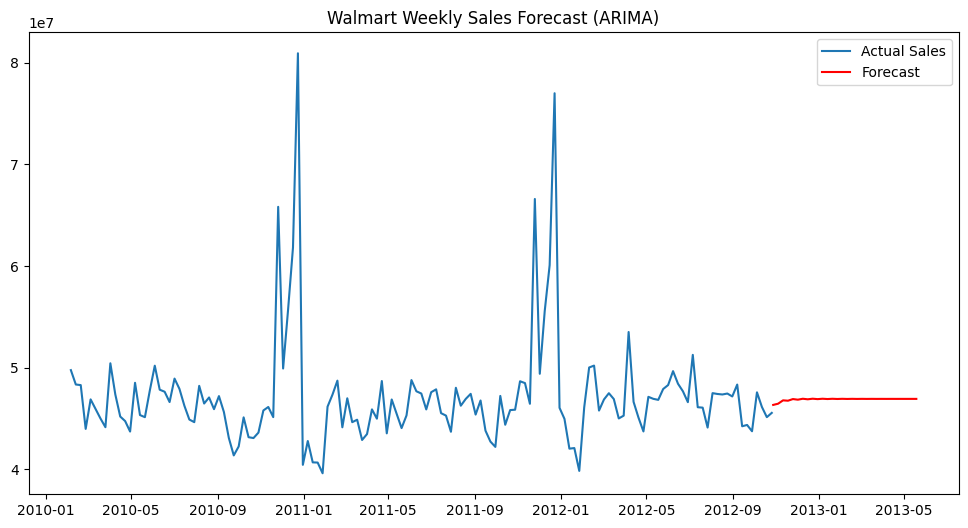

In [5]:
# Forecast next 12 weeks
forecast = model_fit.forecast(steps=30)

# Create forecast index
forecast_index = pd.date_range(sales.index[-1], periods=30, freq="W")

# Plot results
plt.figure(figsize=(12,6))
plt.plot(sales.index, sales["Weekly_Sales"], label="Actual Sales")
plt.plot(forecast_index, forecast, label="Forecast", color="red")
plt.legend()
plt.title("Walmart Weekly Sales Forecast (ARIMA)")
plt.show()

In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Train-test split
train = sales.iloc[:-50]
test = sales.iloc[-50:]
print(train.head())
print(test.head())

model = ARIMA(train["Weekly_Sales"], order=(2,1,2))
model_fit = model.fit()

# Forecast same length as test set
forecast = model_fit.forecast(steps=50)

# RMSE
rmse = np.sqrt(mean_squared_error(test, forecast))
print("ARIMA RMSE:", rmse)

            Weekly_Sales
Date                    
2010-02-05   49750740.50
2010-02-12   48336677.63
2010-02-19   48276993.78
2010-02-26   43968571.13
2010-03-05   46871470.30
            Weekly_Sales
Date                    
2011-11-18   46438980.56
2011-11-25   66593605.26
2011-12-02   49390556.49
2011-12-09   55561147.70
2011-12-16   60085695.94


C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


ARIMA RMSE: 6060803.001918311


In [8]:
# Forecast next 12 weeks
forecast = model_fit.get_forecast(steps=12)
forecast_df = forecast.summary_frame()

# Prepare result dataframe
result = pd.DataFrame({
    "Date": pd.date_range(start=df["Date"].iloc[-1] + pd.Timedelta(days=7), periods=12, freq="W"),
    "Forecast_ARIMA": forecast_df["mean"].values
})

# Merge with original sales
df_results = pd.concat([df[["Date", "Weekly_Sales"]], result], ignore_index=True)

In [10]:
df_results.to_csv("../datasets/arima_forecasts.csv", index=False)
print("✅ ARIMA results saved to arima_forecasts.csv")

✅ ARIMA results saved to arima_forecasts.csv
